# VNNLib Fuzzing with ACTFuzzer

Inference-based whitebox fuzzing on CIFAR-100 VNNLib benchmarks to find counterexamples.

In [2]:
# Setup and imports
import sys, os
act_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.insert(0, act_root) if act_root not in sys.path else None

import torch
import matplotlib.pyplot as plt
import numpy as np
import yaml
from pathlib import Path

# Force reload all fuzzing modules to pick up latest changes
import importlib
modules_to_reload = [
    'act.pipeline.fuzzing.mutations',
    'act.pipeline.fuzzing.coverage',
    'act.pipeline.fuzzing.corpus',
    'act.pipeline.fuzzing.checker',
    'act.pipeline.fuzzing.actfuzzer',
    'act.front_end.model_synthesis',
    'act.front_end.vnnlib_loader.create_specs',
    'act.front_end.vnnlib_loader.vnnlib_parser',
    'act.front_end.vnnlib_loader.onnx_converter',
    'act.front_end.vnnlib_loader.data_model_loader',
]
for mod_name in modules_to_reload:
    if mod_name in sys.modules:
        importlib.reload(sys.modules[mod_name])

from act.front_end.vnnlib_loader.create_specs import VNNLibSpecCreator
from act.front_end.model_synthesis import synthesize_models_from_specs
from act.pipeline.fuzzing.actfuzzer import ACTFuzzer, FuzzingConfig

# CIFAR-100 class names (100 fine-grained classes)
CIFAR100_CLASSES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

print("✓ Setup complete (modules reloaded with batch dimension fixes)")


[ACT] Auto-detecting project root: /Users/z3310488/Documents/workspace/ACT
[ACT] Gurobi license found and set: /Users/z3310488/Documents/workspace/ACT/modules/gurobi/gurobi.lic


/Users/z3310488/miniconda3/envs/act-py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Setup complete (modules reloaded with batch dimension fixes)


## Load VNNLib Benchmark and Run Fuzzing (1-minute budget)

**Note on VNNLib Property Format:**
- VNNLib benchmarks encode robustness as: `Y_i >= Y_true` for all i ≠ true
- This means: "all wrong classes must have logits ≥ true class logit"
- A **counterexample** (violation) occurs when the model predicts a different class (misclassification)
- The fuzzer tries to find inputs within ε that cause misclassification


In [8]:
print("="*80)
print("LOADING CIFAR-100 VNNLIB BENCHMARK")
print("="*80)

# Load VNNLib instances
creator = VNNLibSpecCreator(config_name="vnnlib_default")
spec_results = creator.create_specs_for_data_model_pairs(
    categories=["cifar100_2024"],
    max_instances=20,
    validate_shapes=True
)
print(f"✓ Loaded {len(spec_results)} instances\n")

# Randomly select 3 instances for fuzzing
import random
num_seeds = 3
random_indices = random.sample(range(len(spec_results)), min(num_seeds, len(spec_results)))
print(f"🎲 Randomly selected {len(random_indices)} instances: {[i+1 for i in random_indices]}\n")

selected_instances = [spec_results[i] for i in random_indices]

# Synthesize wrapped models for all selected instances
# Note: synthesize_models_from_specs returns (wrapped_models, reports) tuple
print("Synthesizing wrapped models for selected instances...")
wrapped_models, reports = synthesize_models_from_specs(selected_instances)
print(f"✓ Models wrapped for {len(wrapped_models)} instances\n")

# Load fuzzing config from YAML
config_path = Path(act_root) / "act/pipeline/fuzzing/config.yaml"
with open(config_path) as f:
    yaml_data = yaml.safe_load(f)
    yaml_config = yaml_data['fuzzing']

# Override with 1-minute budget per instance
config = FuzzingConfig(
    max_iterations=yaml_config['max_iterations'],
    timeout_seconds=60.0,  # 1 minute per instance
    device="cuda" if torch.cuda.is_available() else "cpu",
    save_counterexamples=yaml_config['save_counterexamples'],
    output_dir=Path("fuzzing_results_vnnlib"),
    report_interval=yaml_config['report_interval'],
    mutation_weights=yaml_config['mutation_weights']
)

print(f"Fuzzing config: timeout={config.timeout_seconds}s per instance, device={config.device}")
print(f"Mutation weights: {config.mutation_weights}\n")

print("="*80)
print("STARTING FUZZING - ONE MODEL PER INSTANCE")
print("="*80)

# Fuzz each wrapped model independently
all_reports = []
all_fuzzers = []  # Store all fuzzers to access their corpus seeds
instance_info = []

for idx, (combo_id, wrapped_model) in enumerate(wrapped_models.items()):
    # Extract labeled input from model's InputLayer
    input_layer = wrapped_model[0]  # First layer is InputLayer
    labeled_input = input_layer.labeled_input  # LabeledInputTensor
    
    # Extract input spec from InputSpecLayer (second layer)
    input_spec_layer = wrapped_model[1]  # Second layer is InputSpecLayer
    input_spec = input_spec_layer.spec  # Access .spec attribute
    epsilon = float((input_spec.ub - input_spec.lb).max())
    
    # Extract output spec from OutputSpecLayer (last layer)
    output_spec_layer = wrapped_model[-1]  # Last layer is OutputSpecLayer
    output_spec = output_spec_layer.spec  # Access .spec attribute
    
    print(f"\n[{idx+1}/{len(wrapped_models)}] Instance: {combo_id}")
    print(f"   True label: {labeled_input.label} ({CIFAR100_CLASSES[labeled_input.label]})")
    print(f"   Epsilon: {epsilon:.6f}")
    
    # Store instance info for visualization
    instance_info.append({
        'index': idx,
        'input_tensor': labeled_input.tensor,
        'true_label': labeled_input.label,
        'epsilon': epsilon,
        'input_spec': input_spec,
        'combo_id': combo_id
    })
    
    # Run fuzzing with this model's stored input as seed
    fuzzer = ACTFuzzer(
        wrapped_model=wrapped_model,
        initial_seeds=[labeled_input],
        config=config
    )
    report = fuzzer.fuzz()
    all_reports.append(report)
    all_fuzzers.append(fuzzer)  # Store fuzzer for this instance
    
    print(f"   ✓ Iterations: {report.total_iterations}, "
          f"Time: {report.total_time:.2f}s, "
          f"Counterexamples: {len(report.counterexamples)}")

# Aggregate results
print("\n" + "="*80)
print("FUZZING COMPLETE - ALL INSTANCES")
print("="*80)
total_iterations = sum(r.total_iterations for r in all_reports)
total_time = sum(r.total_time for r in all_reports)
total_counterexamples = sum(len(r.counterexamples) for r in all_reports)
avg_coverage = sum(r.neuron_coverage for r in all_reports) / len(all_reports)

print(f"Total iterations: {total_iterations} ({total_iterations / total_time:.1f} it/s)")
print(f"Total time: {total_time:.2f}s")
print(f"Total counterexamples: {total_counterexamples}")
print(f"Average coverage: {avg_coverage:.2%}")
print("="*80)

# Combine all counterexamples and create a unified report for visualization
report = type('CombinedReport', (), {
    'total_iterations': total_iterations,
    'total_time': total_time,
    'counterexamples': [ce for r in all_reports for ce in r.counterexamples],
    'neuron_coverage': avg_coverage,
    'seeds_explored': sum(r.seeds_explored for r in all_reports)
})()


INFO:act.front_end.vnnlib_loader.create_specs:Creating VNNLIB specs: categories=['cifar100_2024'], max_instances=20
INFO:act.front_end.vnnlib_loader.create_specs:Processing 20 VNNLIB instances
INFO:act.front_end.vnnlib_loader.create_specs:Loading instance: cifar100_2024/CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_3965_sidx_688_eps_0.0039
INFO:act.front_end.vnnlib_loader.data_model_loader:Loading VNNLIB instance: cifar100_2024/onnx/CIFAR100_resnet_medium.onnx
INFO:act.front_end.vnnlib_loader.data_model_loader:[1/3] Converting ONNX model to PyTorch...
INFO:act.front_end.vnnlib_loader.onnx_converter:Loading ONNX model from /Users/z3310488/Documents/workspace/ACT/data/vnnlib/cifar100_2024/onnx/CIFAR100_resnet_medium.onnx
INFO:act.front_end.vnnlib_loader.onnx_converter:Converting ONNX to PyTorch
INFO:act.front_end.vnnlib_loader.create_specs:Processing 20 VNNLIB instances
INFO:act.front_end.vnnlib_loader.create_specs:Loading instance: cifar100_2024/CIFAR100_resnet_medium_CIFAR100_

LOADING CIFAR-100 VNNLIB BENCHMARK


INFO:act.front_end.vnnlib_loader.onnx_converter:Converted model to device=cpu, dtype=torch.float64
INFO:act.front_end.vnnlib_loader.onnx_converter:Successfully converted ONNX model: CIFAR100_resnet_medium.onnx
INFO:act.front_end.vnnlib_loader.data_model_loader:  ✓ Model converted successfully
INFO:act.front_end.vnnlib_loader.data_model_loader:[2/3] Extracting input shape...
INFO:act.front_end.vnnlib_loader.onnx_converter:Normalized dynamic batch to 1: (1, 3, 32, 32)
INFO:act.front_end.vnnlib_loader.data_model_loader:  ✓ Input shape: (1, 3, 32, 32)
INFO:act.front_end.vnnlib_loader.data_model_loader:[3/3] Parsing VNNLIB specification...
INFO:act.front_end.vnnlib_loader.onnx_converter:Successfully converted ONNX model: CIFAR100_resnet_medium.onnx
INFO:act.front_end.vnnlib_loader.data_model_loader:  ✓ Model converted successfully
INFO:act.front_end.vnnlib_loader.data_model_loader:[2/3] Extracting input shape...
INFO:act.front_end.vnnlib_loader.onnx_converter:Normalized dynamic batch to 1: 

✓ Loaded 20 instances

🎲 Randomly selected 3 instances: [11, 12, 6]

Synthesizing wrapped models for selected instances...

🧬 Synthesizing models from 3 spec result(s)...
✓ cifar100_2024 + CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_4394_sidx_4782_eps_0.0039: Created 1 wrapped model(s)
✓ cifar100_2024 + CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_8457_sidx_4948_eps_0.0039: Created 1 wrapped model(s)
✓ cifar100_2024 + CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_1642_sidx_7494_eps_0.0039: Created 1 wrapped model(s)

🎉 Synthesized 3 wrapped models from specs!
✓ Models wrapped for 3 instances

Fuzzing config: timeout=60.0s per instance, device=cpu
Mutation weights: {'gradient': 0.4, 'activation': 0.3, 'boundary': 0.2, 'random': 0.1}

STARTING FUZZING - ONE MODEL PER INSTANCE

[1/3] Instance: m:CIFAR100_resnet_medium_CIFAR100_resnet_medium_prop_idx_4394_sidx_4782_eps_0.0039|x:cifar100_2024|s:0|is:BOX|os:RANGE_m0.0
   True label: 48 (motorcycle)
   Epsilon: 0

## Visualize Results


FUZZING SUMMARY
  Iterations: 24471 (135.9 it/s)
  Time: 180.01s
  Seeds explored: 13
  Neuron coverage: 79.01%
  Counterexamples: 0

ORIGINAL INPUTS ANALYSIS
Instance 1: True=motorcycle, Pred=motorcycle (0.730) ✓ Correct
Instance 2: True=tulip, Pred=tulip (0.463) ✓ Correct
Instance 3: True=lion, Pred=lion (0.661) ✓ Correct

SPECIFICATION SUMMARY

Instance 1 - motorcycle:
  InputSpec:
    Kind: BOX
    Shape: torch.Size([1, 3, 32, 32])
    Epsilon (L∞): 0.030590
    Range: [-1.8971, 2.0250]
  VNNLib Property:
    Robustness check: Y_i >= Y_48 for all i ≠ 48
    Meaning: Model should predict 'motorcycle' for all inputs within ε=0.030590

Instance 2 - tulip:
  InputSpec:
    Kind: BOX
    Shape: torch.Size([1, 3, 32, 32])
    Epsilon (L∞): 0.030590
    Range: [-1.8824, 1.9568]
  VNNLib Property:
    Robustness check: Y_i >= Y_92 for all i ≠ 92
    Meaning: Model should predict 'tulip' for all inputs within ε=0.030590

Instance 3 - lion:
  InputSpec:
    Kind: BOX
    Shape: torch.Size([

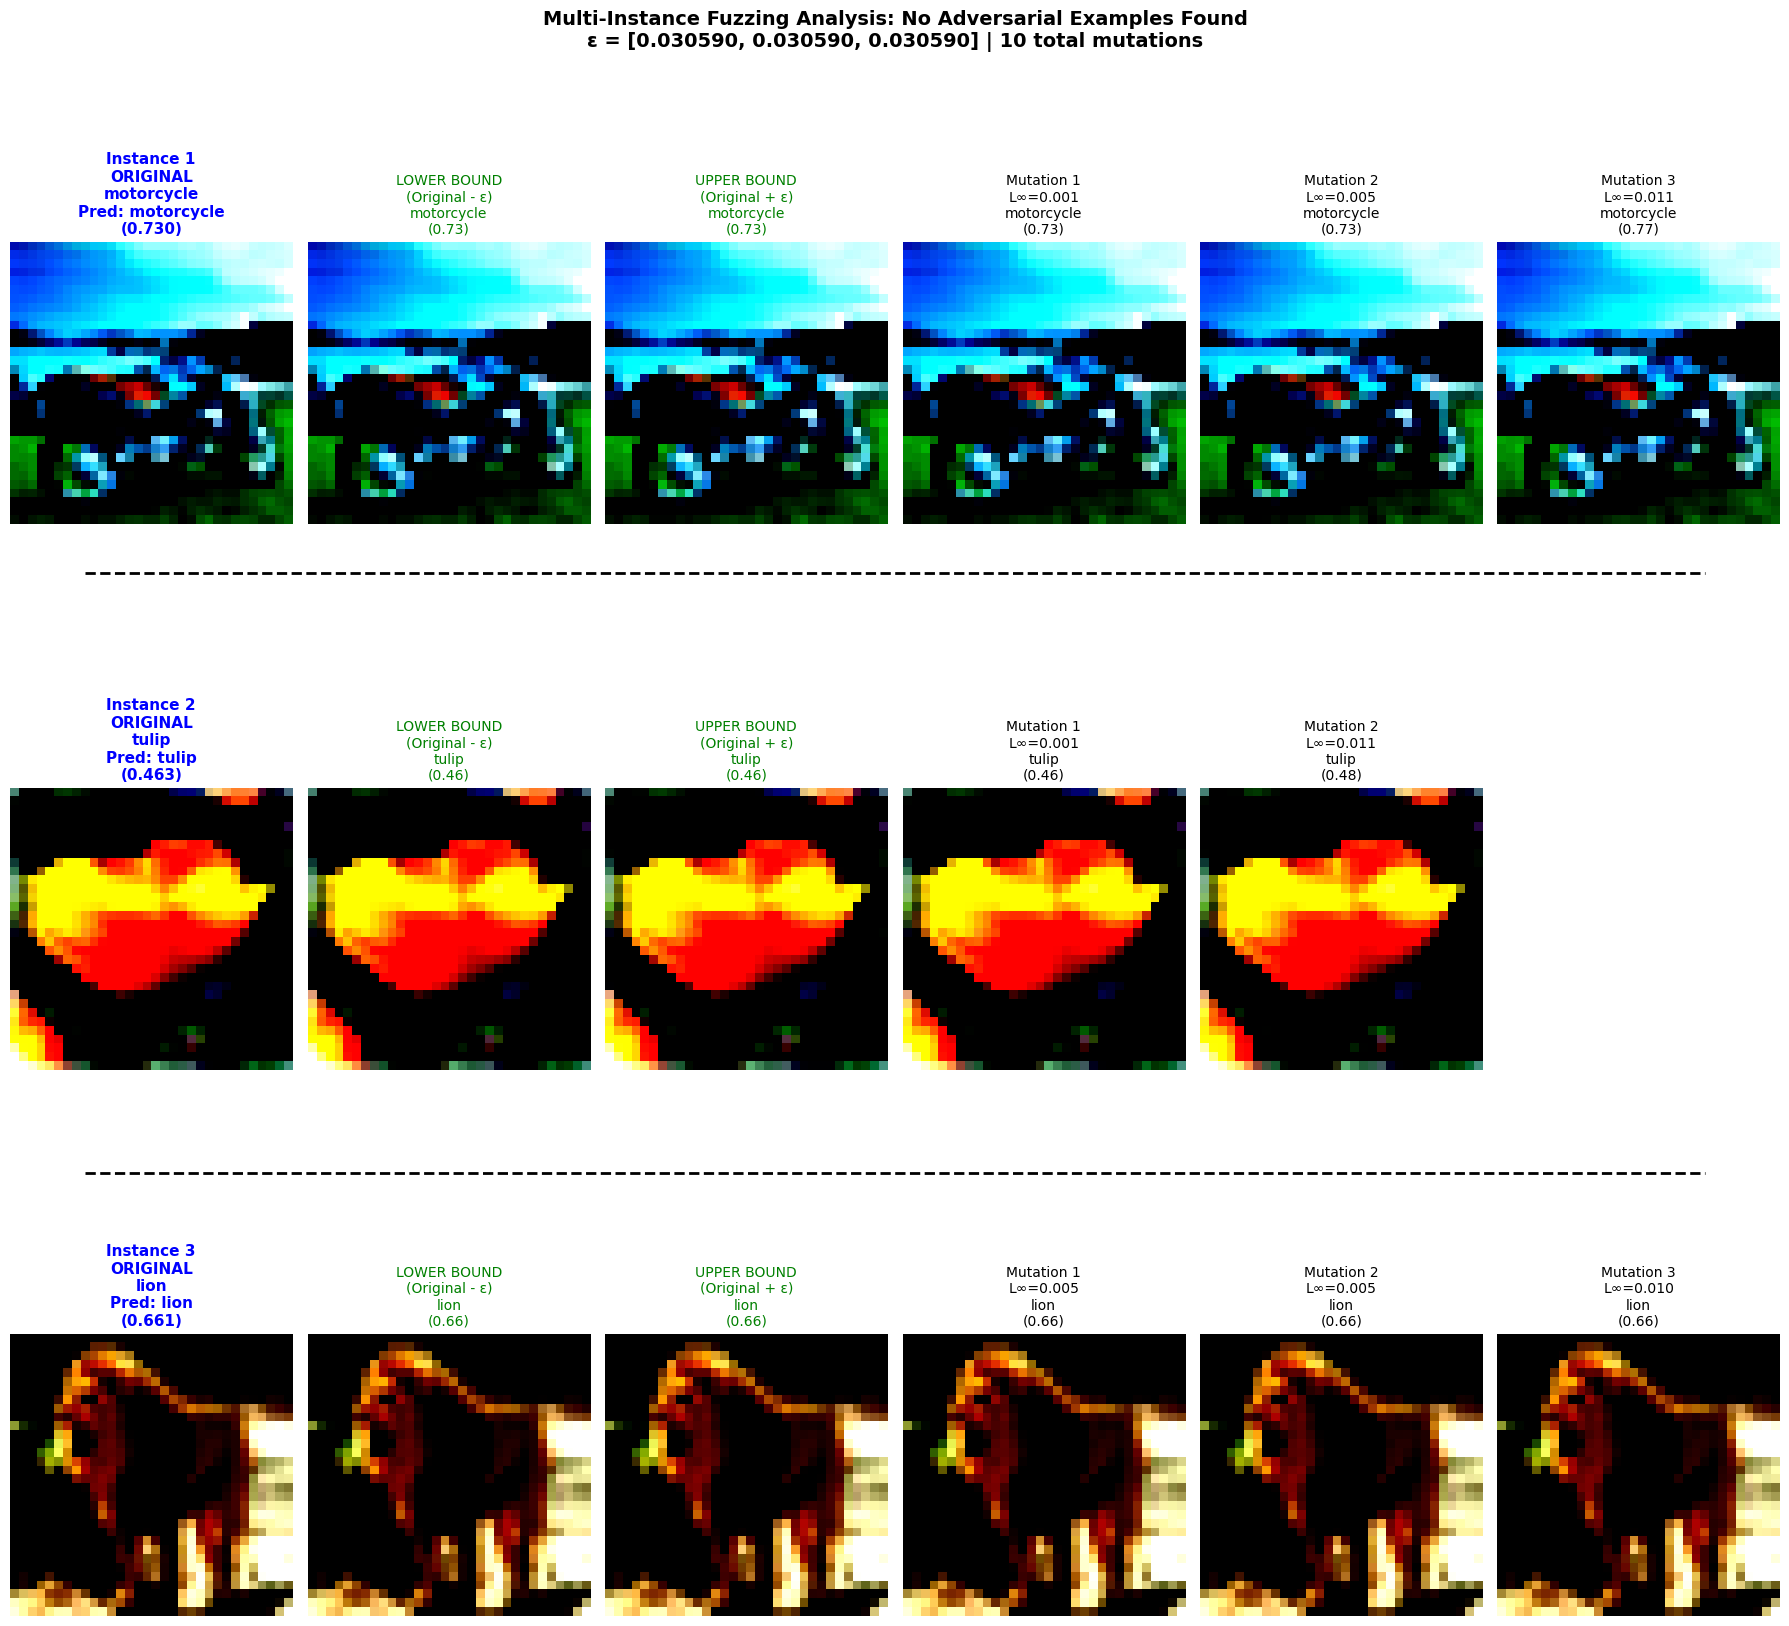


💡 Observations:
  - Tested 3 instances with 10 total perturbation attempts
  - All attempts maintained correct classification for their respective instances
  - Model appears robust for these instances

💡 Suggestions to find counterexamples:
  1. Increase timeout (currently 60.0s)
  2. Try more instances (currently using 3 random instances)
  3. Increase gradient mutation weight (currently 0.4)
  4. Use GPU for faster iterations (currently: cpu)


In [9]:
# Print fuzzing summary first
print(f"\n{'='*80}")
print(f"FUZZING SUMMARY")
print(f"{'='*80}")
print(f"  Iterations: {report.total_iterations} ({report.total_iterations / report.total_time:.1f} it/s)")
print(f"  Time: {report.total_time:.2f}s")
print(f"  Seeds explored: {report.seeds_explored}")
print(f"  Neuron coverage: {report.neuron_coverage:.2%}")
print(f"  Counterexamples: {len(report.counterexamples)}")
print(f"{'='*80}\n")

# Analyze each instance
print(f"{'='*80}")
print(f"ORIGINAL INPUTS ANALYSIS")
print(f"{'='*80}")

# Get list of wrapped models for inference
wrapped_models_list = list(wrapped_models.values())

for info in instance_info:
    input_tensor = info['input_tensor']
    true_label = info['true_label']
    instance_idx = info['index']
    wrapped_model = wrapped_models_list[instance_idx]
    
    # Ensure input has batch dimension
    if input_tensor.dim() == 3:
        input_batch = input_tensor.unsqueeze(0)
    else:
        input_batch = input_tensor
    
    with torch.no_grad():
        orig_output = wrapped_model(input_batch)
        if isinstance(orig_output, dict):
            orig_output = orig_output['output']
        orig_pred = orig_output.argmax(dim=1).item()
        orig_probs = torch.softmax(orig_output[0], dim=0)
        orig_conf = orig_probs[orig_pred].item()
    
    status = "✓ Correct" if orig_pred == true_label else "✗ MISCLASSIFIED"
    print(f"Instance {info['index']+1}: True={CIFAR100_CLASSES[true_label]}, "
          f"Pred={CIFAR100_CLASSES[orig_pred]} ({orig_conf:.3f}) {status}")

print(f"{'='*80}\n")

# Print specification summary
print(f"{'='*80}")
print(f"SPECIFICATION SUMMARY")
print(f"{'='*80}")

for info in instance_info:
    input_spec = info['input_spec']
    epsilon = info['epsilon']
    true_label = info['true_label']
    
    print(f"\nInstance {info['index']+1} - {CIFAR100_CLASSES[true_label]}:")
    print(f"  InputSpec:")
    print(f"    Kind: {input_spec.kind}")
    print(f"    Shape: {input_spec.lb.shape}")
    print(f"    Epsilon (L∞): {epsilon:.6f}")
    print(f"    Range: [{input_spec.lb.min():.4f}, {input_spec.ub.max():.4f}]")
    print(f"  VNNLib Property:")
    print(f"    Robustness check: Y_i >= Y_{true_label} for all i ≠ {true_label}")
    print(f"    Meaning: Model should predict '{CIFAR100_CLASSES[true_label]}' for all inputs within ε={epsilon:.6f}")

print(f"\n{'='*80}\n")

# Create comprehensive visualization
if len(report.counterexamples) > 0:
    print(f"{'='*80}")
    print(f"🎯 FOUND {len(report.counterexamples)} COUNTEREXAMPLE(S)!")
    print(f"{'='*80}\n")
    
    # Show counterexample details
    print(f"COUNTEREXAMPLE DETAILS:\n")
    for idx, ce in enumerate(report.counterexamples[:10]):
        print(f"{idx+1}. {ce.kind}: True={CIFAR100_CLASSES[ce.expected]}, "
              f"Predicted={CIFAR100_CLASSES[ce.actual]}, Conf={ce.confidence:.3f}")
    
    # Visualize counterexamples grouped by original instance
    print(f"\n{'='*80}")
    print(f"COUNTEREXAMPLE VISUALIZATION")
    print(f"{'='*80}\n")
    
    num_show = min(10, len(report.counterexamples))
    fig, axes = plt.subplots(num_show, 3, figsize=(12, 4*num_show))
    if num_show == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'Counterexamples Found: Original → Perturbation → Perturbed', 
                 fontsize=14, fontweight='bold')
    
    for idx in range(num_show):
        ce = report.counterexamples[idx]
        
        # Find which instance this counterexample is closest to
        perturbed = ce.input.squeeze()
        if perturbed.dim() == 1:
            perturbed = perturbed.reshape(3, 32, 32)
        
        # Find closest original
        min_dist = float('inf')
        closest_idx = 0
        for i, info in enumerate(instance_info):
            orig_tensor = info['input_tensor']
            if orig_tensor.dim() == 4:
                orig_tensor = orig_tensor.squeeze(0)
            dist = (perturbed - orig_tensor.reshape(3, 32, 32)).abs().max()
            if dist < min_dist:
                min_dist = dist
                closest_idx = i
        
        orig_info = instance_info[closest_idx]
        orig_tensor = orig_info['input_tensor']
        if orig_tensor.dim() == 4:
            orig_tensor = orig_tensor.squeeze(0)
        orig_tensor = orig_tensor.reshape(3, 32, 32)
        
        # Original image
        orig_img = orig_tensor.permute(1, 2, 0)
        orig_img_np = np.clip(orig_img.cpu().numpy(), 0, 1)
        
        # Perturbed image
        perturbed_img = perturbed.permute(1, 2, 0)
        perturbed_img_np = np.clip(perturbed_img.cpu().numpy(), 0, 1)
        
        # Perturbation (difference)
        diff = perturbed - orig_tensor
        diff_img = diff.permute(1, 2, 0)
        diff_img_np = diff_img.cpu().numpy()
        # Normalize diff for visualization
        diff_vis = (diff_img_np - diff_img_np.min()) / (diff_img_np.max() - diff_img_np.min() + 1e-8)
        
        # Plot original
        axes[idx, 0].imshow(orig_img_np, interpolation='nearest')
        axes[idx, 0].set_title(f'Original (Inst {closest_idx+1})\n{CIFAR100_CLASSES[ce.expected]}', 
                                fontsize=9, color='green', fontweight='bold')
        axes[idx, 0].axis('off')
        
        # Plot perturbation
        axes[idx, 1].imshow(diff_vis, interpolation='nearest')
        l_inf = diff.abs().max().item()
        axes[idx, 1].set_title(f'Perturbation\nL∞={l_inf:.4f}', fontsize=9)
        axes[idx, 1].axis('off')
        
        # Plot perturbed
        axes[idx, 2].imshow(perturbed_img_np, interpolation='nearest')
        axes[idx, 2].set_title(f'Perturbed\n{CIFAR100_CLASSES[ce.actual]}\nConf={ce.confidence:.2f}', 
                                fontsize=9, color='red', fontweight='bold')
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Successfully found adversarial examples!")

else:
    print(f"{'='*80}")
    print(f"⚠️  NO COUNTEREXAMPLES FOUND")
    print(f"{'='*80}\n")
    
    print(f"Fuzzing Summary:")
    print(f"  - Iterations: {report.total_iterations}")
    print(f"  - Seeds explored: {report.seeds_explored}")
    print(f"  - Neuron coverage: {report.neuron_coverage:.2%}")
    print(f"  - Time: {report.total_time:.1f}s\n")
    
    # Create visualization: one row per instance with larger images
    print("Creating visualization for all instances...\n")
    
    num_instances = len(instance_info)
    
    # One row per instance, showing: Original | LB | UB | 3 Attempts
    # Total 6 columns per row
    fig, axes = plt.subplots(num_instances, 6, figsize=(18, 6 * num_instances))
    if num_instances == 1:
        axes = axes.reshape(1, -1)
    
    for inst_idx, info in enumerate(instance_info):
        input_tensor = info['input_tensor']
        true_label = info['true_label']
        input_spec = info['input_spec']
        epsilon = info['epsilon']
        wrapped_model = wrapped_models_list[inst_idx]
        
        # Get corpus seeds for THIS instance's fuzzer
        instance_fuzzer = all_fuzzers[inst_idx]
        instance_corpus_seeds = list(instance_fuzzer.seed_corpus.seeds)
        
        # Ensure input_tensor is 3D (C, H, W) for visualization
        if input_tensor.dim() == 4:
            input_tensor = input_tensor.squeeze(0)
        
        # Get prediction on original (needs batch dimension)
        input_batch = input_tensor.unsqueeze(0)
        with torch.no_grad():
            orig_output = wrapped_model(input_batch)
            if isinstance(orig_output, dict):
                orig_output = orig_output['output']
            orig_pred = orig_output.argmax(dim=1).item()
            orig_probs = torch.softmax(orig_output[0], dim=0)
            orig_conf = orig_probs[orig_pred].item()
        
        # Column 0: Original
        orig_img = input_tensor.reshape(3, 32, 32).permute(1, 2, 0)
        orig_img_np = np.clip(orig_img.cpu().numpy(), 0, 1)
        axes[inst_idx, 0].imshow(orig_img_np, interpolation='nearest')
        axes[inst_idx, 0].set_title(f'Instance {inst_idx+1}\nORIGINAL\n{CIFAR100_CLASSES[true_label]}\n'
                                     f'Pred: {CIFAR100_CLASSES[orig_pred]}\n({orig_conf:.3f})',
                                     fontsize=11, color='blue', fontweight='bold')
        axes[inst_idx, 0].axis('off')
        
        # Column 1: Lower Bound
        lb_tensor = input_spec.lb
        if lb_tensor.dim() == 4:
            lb_tensor = lb_tensor.squeeze(0)
        lb_tensor = lb_tensor.reshape(3, 32, 32)
        lb_img = lb_tensor.permute(1, 2, 0)
        lb_img_np = np.clip(lb_img.cpu().numpy(), 0, 1)
        axes[inst_idx, 1].imshow(lb_img_np, interpolation='nearest')
        
        with torch.no_grad():
            lb_output = wrapped_model(lb_tensor.unsqueeze(0))
            if isinstance(lb_output, dict):
                lb_output = lb_output['output']
            lb_pred = lb_output.argmax(dim=1).item()
            lb_probs = torch.softmax(lb_output[0], dim=0)
            lb_conf = lb_probs[lb_pred].item()
        
        axes[inst_idx, 1].set_title(f'LOWER BOUND\n(Original - ε)\n{CIFAR100_CLASSES[lb_pred]}\n({lb_conf:.2f})',
                                     fontsize=10, color='red' if lb_pred != true_label else 'green')
        axes[inst_idx, 1].axis('off')
        
        # Column 2: Upper Bound
        ub_tensor = input_spec.ub
        if ub_tensor.dim() == 4:
            ub_tensor = ub_tensor.squeeze(0)
        ub_tensor = ub_tensor.reshape(3, 32, 32)
        ub_img = ub_tensor.permute(1, 2, 0)
        ub_img_np = np.clip(ub_img.cpu().numpy(), 0, 1)
        axes[inst_idx, 2].imshow(ub_img_np, interpolation='nearest')
        
        with torch.no_grad():
            ub_output = wrapped_model(ub_tensor.unsqueeze(0))
            if isinstance(ub_output, dict):
                ub_output = ub_output['output']
            ub_pred = ub_output.argmax(dim=1).item()
            ub_probs = torch.softmax(ub_output[0], dim=0)
            ub_conf = ub_probs[ub_pred].item()
        
        axes[inst_idx, 2].set_title(f'UPPER BOUND\n(Original + ε)\n{CIFAR100_CLASSES[ub_pred]}\n({ub_conf:.2f})',
                                     fontsize=10, color='red' if ub_pred != true_label else 'green')
        axes[inst_idx, 2].axis('off')
        
        # Columns 3-5: 3 perturbation attempts from THIS instance's corpus
        instance_seeds = []
        for seed in instance_corpus_seeds:
            seed_tensor = seed.tensor
            if seed_tensor.dim() == 4:
                seed_tensor = seed_tensor.squeeze(0)
            seed_tensor = seed_tensor.reshape(3, 32, 32)
            dist = (seed_tensor - input_tensor.reshape(3, 32, 32)).abs().max().item()
            if dist <= epsilon * 2:  # Within reasonable range
                instance_seeds.append((seed, dist))
        
        # Sort by distance and take closest 3 (excluding the original which has dist ~0)
        instance_seeds.sort(key=lambda x: x[1])
        # Skip seeds that are too close to the original (likely the original itself)
        instance_seeds = [s for s in instance_seeds if s[1] > 1e-6][:3]
        
        for seed_idx, (seed, dist) in enumerate(instance_seeds):
            col = 3 + seed_idx
            
            seed_tensor = seed.tensor
            if seed_tensor.dim() == 4:
                seed_tensor = seed_tensor.squeeze(0)
            seed_tensor = seed_tensor.reshape(3, 32, 32)
            img = seed_tensor.permute(1, 2, 0)
            img_np = np.clip(img.cpu().numpy(), 0, 1)
            
            # Compute perturbation from this instance's original
            diff = seed_tensor - input_tensor.reshape(3, 32, 32)
            l_inf = diff.abs().max().item()
            
            # Get prediction
            with torch.no_grad():
                seed_output = wrapped_model(seed_tensor.unsqueeze(0))
                if isinstance(seed_output, dict):
                    seed_output = seed_output['output']
                seed_pred = seed_output.argmax(dim=1).item()
                seed_probs = torch.softmax(seed_output[0], dim=0)
                seed_conf = seed_probs[seed_pred].item()
            
            axes[inst_idx, col].imshow(img_np, interpolation='nearest')
            title_color = 'red' if seed_pred != true_label else 'black'
            axes[inst_idx, col].set_title(f'Mutation {seed_idx+1}\nL∞={l_inf:.3f}\n'
                                          f'{CIFAR100_CLASSES[seed_pred]}\n({seed_conf:.2f})',
                                          fontsize=10, color=title_color, fontweight='bold' if seed_pred != true_label else 'normal')
            axes[inst_idx, col].axis('off')
        
        # Fill empty columns if less than 3 attempts
        for empty_col in range(3 + len(instance_seeds), 6):
            axes[inst_idx, empty_col].axis('off')
    
    # Add horizontal dash lines between rows
    for inst_idx in range(num_instances - 1):
        line_y = (inst_idx + 1) / num_instances
        fig.add_artist(plt.Line2D([0.05, 0.95], [line_y, line_y],
                                   transform=fig.transFigure, 
                                   color='black', linewidth=2, linestyle='--'))
    
    # Add epsilon annotation to title
    epsilon_list = [f"{info['epsilon']:.6f}" for info in instance_info]
    epsilon_str = f"ε = [{', '.join(epsilon_list)}]"
    
    # Count total mutations across all instances
    total_mutations = sum(len([s for s in all_fuzzers[i].seed_corpus.seeds if (s.tensor.squeeze().reshape(3,32,32) - instance_info[i]['input_tensor'].squeeze().reshape(3,32,32)).abs().max().item() > 1e-6]) for i in range(num_instances))
    
    plt.suptitle(f'Multi-Instance Fuzzing Analysis: No Adversarial Examples Found\n{epsilon_str} | {total_mutations} total mutations', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
    print(f"\n💡 Observations:")
    print(f"  - Tested {len(instance_info)} instances with {total_mutations} total perturbation attempts")
    print(f"  - All attempts maintained correct classification for their respective instances")
    print(f"  - Model appears robust for these instances")
    print(f"\n💡 Suggestions to find counterexamples:")
    print(f"  1. Increase timeout (currently {config.timeout_seconds}s)")
    print(f"  2. Try more instances (currently using {len(instance_info)} random instances)")
    print(f"  3. Increase gradient mutation weight (currently {config.mutation_weights.get('gradient', 0)})")
    print(f"  4. Use GPU for faster iterations (currently: {config.device})")
